In [1]:
%cd '~/Dev/sdo_tracking_framework'
import os, glob
import time
import numpy as np
from scipy.io import readsav
import matplotlib.pyplot as plt
import fitsio
from astropy.io import fits
from scipy.ndimage.filters import gaussian_filter 
from scipy.signal import convolve2d

/Users/rattie/Dev/sdo_tracking_framework


In [7]:
def calc_c_pearson(vx1, vx2, vy1, vy2, fov=None):
    vx1f, vx2f, vy1f, vy2f = vx1[fov], vx2[fov], vy1[fov], vy2[fov]
    c_pearson = np.sum(vx1f*vx2f + vy1f*vy2f) / np.sqrt(np.sum(vx1f**2 + vy1f**2)*np.sum(vx2f**2 + vy2f**2))
    return c_pearson

def load_vel_mean(v_files, trange):
    "Load the velocity files and average over a time range"
    vxs = []
    vys = []
    vx_files_subset = v_files[0][trange[0]:trange[1]]
    vy_files_subset = v_files[1][trange[0]:trange[1]]
    for vxf, vyf in zip(vx_files_subset, vy_files_subset):
        vxs.append(fitsio.read(vxf))
        vys.append(fitsio.read(vyf))
    # Get the mean of the velocity components
    vx = np.array(vxs).mean(axis=0)
    vy = np.array(vys).mean(axis=0)
    return vx, vy

def load_vels_mean(v_files1, v_files2, trange):
    "Load two pairs of velocity components data, average them and output the averaged pairs of velocity components"
    vx1, vy1 = load_vel_mean(v_files1, trange)
    vx2, vy2 = load_vel_mean(v_files2, trange)
    return vx1, vy1, vx2, vy2

def smooth_vel(vxs, vys, fwhm, kernel='boxcar'):
    """ Smooth the velocity with a smoothing kernel that can either be: 
     - boxcar: width set to fwhm
     - gaussian: parametrized by fwhm. 
     
     Returns the smoothed velocity components
    """ 
    
    if kernel == 'boxcar':
        box = np.ones([fwhm, fwhm])
        vxs2 = convolve2d(vxs, box, mode='same')
        vys2 = convolve2d(vys, box, mode='same')
    elif kernel == 'gaussian':
        sigma = fwhm / 2.35
        vxs2 = gaussian_filter(vxs, sigma=sigma, order=0)
        vys2 = gaussian_filter(vys, sigma=sigma, order=0)
        
    return vxs2, vys2


In [25]:
# Parent directories of the velocities
data_dir_stein = os.path.join(os.environ['DATA'], 'Ben/SteinSDO/')
data_dir_deepvel = os.path.join(os.environ['DATA'],'Ben/SteinSDO/output_newDeepVel_without_edge_effect/')
# output directory for the plots
plot_dir = os.path.join(os.environ['DATA'], 'Ben/SteinSDO/comparisons')
# Select a subfield excluding edge effects
imsize = 263 # actual size is 264 but original size was 263 then padded to 264 to make it even for the Fourier transform
# Use same padding size as in Tremblay et al. 2018 used pad = 10
pad = 10
fov = np.s_[pad:imsize - pad, pad:imsize-pad]


## Load data from simulation - Deepvel DeepvelU

In [18]:
# Simulation
svx_files = sorted(glob.glob(os.path.join(data_dir_stein,'SDO_vx*.fits')))
svy_files = sorted(glob.glob(os.path.join(data_dir_stein,'SDO_vy*.fits')))
# Deepvel
dvx_files = sorted(glob.glob(os.path.join(data_dir_deepvel, 'DeepVel_vx1_drift_*.fits')))
dvy_files = sorted(glob.glob(os.path.join(data_dir_deepvel, 'DeepVel_vy1_drift_*.fits')))
# DeepvelU
dvu = fitsio.read('~/Data/Ben/DeepVelU_QS/stein_output_80frames.fits')
dvux, dvuy = dvu[...,1], dvu[...,0]
print(len(svx_files), len(dvx_files))

364 79


# Calculate correlations with simulation

In [19]:
# Time windows at increasing sizes
twin = np.arange(29, 80, 5)
tranges = [[0, f] for f in twin]
# Smoothing kernel 
kernel = 'boxcar'
tranges

[[0, 29],
 [0, 34],
 [0, 39],
 [0, 44],
 [0, 49],
 [0, 54],
 [0, 59],
 [0, 64],
 [0, 69],
 [0, 74],
 [0, 79]]

In [20]:
# Load stein and deepvel, with time average. DeepvelU is done separately
vx_stein, vy_stein, vx_dv, vy_dv  = zip(*[load_vels_mean((svx_files, svy_files), (dvx_files, dvy_files), trange) for trange in tranges])

In [21]:
# Time average deepvelU
dvux = [dvux[trange[0]:trange[1], ...].mean(axis=0) for trange in tranges]
dvuy = [dvuy[trange[0]:trange[1], ...].mean(axis=0) for trange in tranges]

In [22]:
# smooth Stein velocities, deepvel & deepvelU
fwhm = 7
vx_stein1, vy_stein1 = zip(*[smooth_vel(vx, vy, fwhm, kernel=kernel) for vx, vy in zip(vx_stein, vy_stein)])
vx_dv1, vy_dv1 = zip(*[smooth_vel(vx, vy, fwhm, kernel=kernel) for vx, vy in zip(vx_dv, vy_dv)])
vx_dvu1, vy_dvu1 = zip(*[smooth_vel(vx, vy, fwhm, kernel=kernel) for vx, vy in zip(dvux, dvuy)])

fwhm = 14
vx_stein2, vy_stein2 = zip(*[smooth_vel(vx, vy, fwhm, kernel=kernel) for vx, vy in zip(vx_stein, vy_stein)])
vx_dv2, vy_dv2 = zip(*[smooth_vel(vx, vy, fwhm, kernel=kernel) for vx, vy in zip(vx_dv, vy_dv)])
vx_dvu2, vy_dvu2 = zip(*[smooth_vel(vx, vy, fwhm, kernel=kernel) for vx, vy in zip(dvux, dvuy)])

In [28]:
# Pearson correlation coefficients
c_pearsons_dv0 = [calc_c_pearson(vx_stein[i], vx_dv[i], vy_stein[i], vy_dv[i], fov=fov) for i in range(len(tranges))]
c_pearsons_dvu0 = [calc_c_pearson(vx_stein[i], dvux[i], vy_stein[i], dvuy[i], fov=fov) for i in range(len(tranges))]

c_pearsons_dv1 = [calc_c_pearson(vx_stein1[i], vx_dv1[i], vy_stein1[i], vy_dv1[i], fov=fov) for i in range(len(tranges))]
c_pearsons_dvu1 = [calc_c_pearson(vx_stein1[i], vx_dvu1[i], vy_stein1[i], vy_dvu1[i], fov=fov) for i in range(len(tranges))]

c_pearsons_dv2 = [calc_c_pearson(vx_stein2[i], vx_dv2[i], vy_stein2[i], vy_dv2[i], fov=fov) for i in range(len(tranges))]
c_pearsons_dvu2 = [calc_c_pearson(vx_stein2[i], vx_dvu2[i], vy_stein2[i], vy_dvu2[i], fov=fov) for i in range(len(tranges))]

c_flct_1 = [0.886128, 0.901866, 0.912868, 0.920165, 0.925326, 0.930060, 0.934065, 0.938544, 0.942697, 0.945828, 0.947722]
c_flct_2 = [0.951687, 0.958069, 0.962598, 0.964175, 0.965511, 0.967933, 0.971079, 0.973734, 0.975885, 0.977513, 0.978452]
c_balltrack_1 = [0.901340, 0.912416, 0.920736, 0.926359, 0.931158, 0.935119, 0.939836, 0.943042, 0.945690, 0.948078, 0.949647]
c_balltrack_2 = [0.952577, 0.957190, 0.962174, 0.965206, 0.969162, 0.971073, 0.973680, 0.975306, 0.976398, 0.977802, 0.978774]




/Users/rattie/Data/Ben/SteinSDO/comparisons


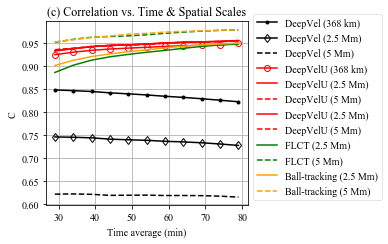

In [32]:
%matplotlib inline
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 10
plt.figure(figsize=(5.5,3.5))

plt.plot(twin, c_pearsons_dv0, marker='.', color='black', label='DeepVel (368 km)')
plt.plot(twin, c_pearsons_dv1, marker='d', markerfacecolor='none', color='black', label='DeepVel (2.5 Mm)')
plt.plot(twin, c_pearsons_dv2, color='black', ls='--', label='DeepVel (5 Mm)')

plt.plot(twin, c_pearsons_dvu0, marker='o', markerfacecolor='none', color='red', label='DeepVelU (368 km)')
plt.plot(twin, c_pearsons_dvu1, color='red', label='DeepVelU (2.5 Mm)')
plt.plot(twin, c_pearsons_dvu2, color='red', ls='--', label='DeepVelU (5 Mm)')

plt.plot(twin, c_pearsons_dvu1, color='red', label='DeepVelU (2.5 Mm)')
plt.plot(twin, c_pearsons_dvu2, color='red', ls='--', label='DeepVelU (5 Mm)')

plt.plot(twin, c_flct_1, color='green', ls='-', label='FLCT (2.5 Mm)')
plt.plot(twin, c_flct_2, color='green', ls='--', label='FLCT (5 Mm)')

plt.plot(twin, c_balltrack_1, color='orange', ls='-', label='Ball-tracking (2.5 Mm)')
plt.plot(twin, c_balltrack_2, color='orange', ls='--', label='Ball-tracking (5 Mm)')

plt.xlabel('Time average (min)')
plt.ylabel('C')
plt.grid(True)
plt.title('(c) Correlation vs. Time & Spatial Scales')
plt.legend(framealpha=0.5, loc='lower left', bbox_to_anchor=(1, 0))
#plt.ylim([0.5, 1.0])
plt.tight_layout()
plt.savefig(os.path.join(plot_dir, 'corr_DV_FLCT_Balltrack.png'), dpi=300)
plt.savefig(os.path.join(plot_dir, 'corr_DV_FLCT_Balltrack.png'), dpi=300)
print(plot_dir)


In [102]:
8 * 368 / 1000

2.944

In [ ]:
abs_vh1_dv=np.sqrt((vx1_ref-vx1_dv)**2+(vy1_ref-vy1_dv)**2)
err_vh1_dv=np.sqrt((vx1_ref-vx1_dv)**2+(vy1_ref-vy1_dv)**2)/np.sqrt(vx1_ref**2+vy1_ref**2)